In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [2]:
username = 'francisandrew69'

SPOTIPY_CLIENT_ID = '39449617f556485bb1565002c8307faa'

SPOTIPY_CLIENT_SECRET = 'bbe8bf01264f4e48809ce317eab7e5bf'

SPOTIPY_REDIRECT_URI = 'http://localhost:8888/callback'

os.environ['SPOTIPY_CLIENT_ID'] = '39449617f556485bb1565002c8307faa'

os.environ['SPOTIPY_CLIENT_SECRET'] = 'bbe8bf01264f4e48809ce317eab7e5bf'

os.environ['SPOTIPY_REDIRECT_URI'] = 'http://localhost:8888/callback'

# Select two artists that you want to build a customized playlist around
selected_artists = [ 'Moon Hooch', 'The Budos Band' ]

In [3]:
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

# Define Utility Functions

In [4]:
# Flatten a list of lists to a single continuous list
def flatten_list( list_of_lists ):
    
    return [item for sublist in list_of_lists for item in sublist]

In [5]:
# Extract items from Spotify dictionaries returned by the API
def extract_items( item_object, item_id, root_source = 'items' ):
    
    items = []
    
    for item in item_object[root_source]:

        items.append( item[ item_id ] )
        
    return items

In [6]:
# Get artist IDs from a list of artist names
def get_artist_id( artists ): 
    
    artist_ids = []
    
    for artist in artists: 
        
        results = spotify.search( q = 'artist:' + artist, type='artist' )
        
        try:
            artist_id = results['artists']['items'][0]['id']
        except:
            #artist_id = artist
            None
        
        artist_ids.append( artist_id )
        
    return artist_ids

In [7]:
# Pull the names of realted artists based on a list of artists
def get_related_artists( artists ):
    
    related_artists = [ artists ]
    
    for artist in artists: 
        
        related = spotify.artist_related_artists( get_artist_id( [artist] )[0] )
        
        related = extract_items( related, 'name', root_source = 'artists' )
        
        related_artists.append( related )
        
    related_artists = set( flatten_list( related_artists ) )
        
    return list( related_artists )

In [8]:
#Creates a lookup table containing the base artists and the artists that are related to them
def artist_lookup_table( artists ): 
    
    related_artists = []
    
    base_artist = []
    
    for artist in artists: 
        
        related = get_related_artists( [artist] )
        
        base = [artist]*len(related)
        
        related_artists.append(related)
        
        base_artist.append(base)
        
    related_artists = flatten_list( related_artists )
    
    base_artist = flatten_list( base_artist )
    
    df = pd.DataFrame([base_artist, related_artists], index = ['Base Artist', 'Related']).T
        
    return df
       

In [9]:
# Pull album names for a list of given artist names
def get_artist_albums( artists ):
    
    artist_ids = get_artist_id( artists )
    
    artist_index = 0 
    
    artist_albums = { }
    
    for artist_id in artist_ids:
        
        artist = artists[ artist_index ]
    
        albums = spotify.artist_albums( artist_id = artist_id, album_type = 'album' )

        album_ids = []

        album_names = []

        for item in albums['items']:

            album_ids.append( item['id'] )

            album_names.append( item['name'] )

        artist_albums[ artist ] = { }

        artist_albums[ artist ]['album_ids'] = album_ids

        artist_albums[ artist ]['album_names'] = album_names

        artist_index += 1
        
    return artist_albums

ab_info = get_artist_albums( artists = selected_artists )

In [10]:
# Pull every track produced by a list of artists
def get_artist_tracks( artists ): 
    
    album_info = get_artist_albums( artists )
    
    for artist in artists:
        
        album_ids = album_info[ artist ][ 'album_ids' ]
        
        all_track_names = []
        
        all_track_ids = []
        
        for album_id in album_ids: 
        
            tracks = spotify.album_tracks( album_id )
            
            track_names = extract_items( tracks, item_id = 'name' )
            
            all_track_names.append( track_names )
            
            track_ids = extract_items( tracks, item_id = 'id' )
            
            all_track_ids.append( track_ids )
            
        all_track_names = [item for sublist in all_track_names for item in sublist]
        
        all_track_ids = [item for sublist in all_track_ids for item in sublist]
            
        album_info[ artist ]['track_names'] = all_track_names
        
        album_info[ artist ]['track_ids'] = all_track_ids
        
    return album_info


In [11]:
# Based on a dictionary of tracks, pull the realted audio features
def get_track_feature_df( tracks, artist_pair ):
    
    all_artist_names = []

    all_track_ids = []

    all_track_names = []

    for key in tracks.keys():

        track_ids = tracks[key]['track_ids']

        track_names = tracks[key]['track_names']

        artist_names = [key]*len(track_names)

        all_artist_names.append(artist_names) 

        all_track_ids.append(track_ids) 

        all_track_names.append(track_names) 

    all_artist_names = flatten_list( all_artist_names )

    all_track_ids = flatten_list( all_track_ids )

    all_track_names = flatten_list( all_track_names )

    all_track_features = []

    start = 0

    for i in range(100, len(all_track_ids), 100 ):

        track_audio_features = spotify.audio_features(tracks=all_track_ids[start:i])

        all_track_features.append( track_audio_features )

        start = i

        
    if (len(all_track_ids) % 100 ) > 0:
        
        track_audio_features = spotify.audio_features(tracks=all_track_ids[start:])

        all_track_features.append( track_audio_features )

    all_track_features = flatten_list(all_track_features)
    
    types = []

    for i in  all_track_features: 

        types.append( type( i ) )

    no_nulls = [np.array( types ) != type(None)][0]
    
    no_null_tracks = list( np.array(all_track_features)[no_nulls] )
    
    all_artist_names = list(np.array(all_artist_names)[no_nulls])

    all_track_ids = list(np.array(all_track_ids)[no_nulls])

    all_track_names = list(np.array(all_track_names)[no_nulls])
    
    
    track_feature_df = pd.DataFrame( no_null_tracks )

    track_feature_df = track_feature_df[track_feature_df.columns[0:11]]

    track_feature_df['Artist'] = all_artist_names

    track_feature_df['Track Name'] = all_track_names

    track_feature_df['Track ID'] = all_track_ids

    artist_lookup = artist_lookup_table( artist_pair ).drop_duplicates( 'Related' )

    track_feature_df = track_feature_df.merge( artist_lookup, left_on = 'Artist', right_on = 'Related', how = 'left' ).drop('Related', axis = 1)

    track_feature_df['Base Artist Col'] = track_feature_df['Base Artist']

    track_feature_df['Artist Col'] = track_feature_df['Artist']

    track_feature_df = track_feature_df.set_index( ['Base Artist', 'Artist'] )

    return  track_feature_df


In [12]:
# Based on a list of two artists, pull all songs from those artists and similar artists then find the most similar 
# songs in that pool of songs 
def get_similar_tracks(artist_pair = [ '2Pac', 'Pink Floyd' ], get_related = True, scaleing = None, 
                       sim_metric = 'cosine', random_top_tracks = False ):
    
    assert len( artist_pair ) == 2, 'You can only select 2 artists'
    
    selected_artists = artist_pair
    
    if get_related:

        related_artists = get_related_artists( selected_artists )
        
        tracks = get_artist_tracks( related_artists )
        
    else:
        
        tracks = get_artist_tracks( selected_artists )

    track_feature_df = get_track_feature_df( tracks, artist_pair = selected_artists )

    audio_feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


    # Create information lookup tables

    track_lookup = track_feature_df[['Track ID', 'Track Name']]

    artist_lookup = track_feature_df[['Track ID', 'Artist Col']]

    # Pull and preprocess the audio analysis data

    audio_info = np.array( track_feature_df[audio_feature_cols] )
    
    if scaleing == None:

        scaler = StandardScaler( with_mean = False, with_std = False )
        
    elif scaleing == 'center':
        
        scaler = StandardScaler( with_mean = True, with_std = False )
        
    elif scaleing == 'standardize':
        
        scaler = StandardScaler( with_mean = True, with_std = True )

    pca_data = scaler.fit_transform( audio_info )



    # Pull the track info for a the respective artists
    
    if get_related == False:

        artist1_audio = pca_data[track_feature_df['Artist Col']==selected_artists[0]]

        artist1_tracks = track_feature_df['Track ID'][track_feature_df['Artist Col']==selected_artists[0]].values

        artist2_audio = pca_data[track_feature_df['Artist Col']==selected_artists[1]]

        artist2_tracks = track_feature_df['Track ID'][track_feature_df['Artist Col']==selected_artists[1]].values
        
    else:
        
        artist1_audio = pca_data[track_feature_df['Base Artist Col']==selected_artists[0]]

        artist1_tracks = track_feature_df['Track ID'][track_feature_df['Base Artist Col']==selected_artists[0]].values

        artist2_audio = pca_data[track_feature_df['Base Artist Col']==selected_artists[1]]

        artist2_tracks = track_feature_df['Track ID'][track_feature_df['Base Artist Col']==selected_artists[1]].values


    # Get the cosine similarity between the artist.related artist tracks
    
    if sim_metric == 'cosine':
        
        dist = cosine_similarity(artist1_audio, artist2_audio)
        
    elif sim_metric == 'euclidean': 
        
        dist = euclidean_distances(artist1_audio, artist2_audio)
        
    elif sim_metric == 'both': 
        
        cos_dist = cosine_similarity(artist1_audio, artist2_audio)
        
        eu_dist = euclidean_distances(artist1_audio, artist2_audio)
        
        eu_dist = 1 / eu_dist
        
        dist = np.multiply( cos_dist, eu_dist )

    sims = pd.DataFrame( dist, columns = artist2_tracks, index = artist1_tracks ).stack()

    percentile_75 = sims.describe()[-2]

    sim_track_pairs = sims[sims > percentile_75]

    sim_track_pairs = sim_track_pairs.reset_index()

    sim_track_pairs = sim_track_pairs.merge( track_lookup, left_on = 'level_0', right_on = 'Track ID', how = 'left' )

    sim_track_pairs = sim_track_pairs.drop( 'Track ID', axis = 1 )

    col1_name = selected_artists[0] + '_Tracks'

    sim_track_pairs = sim_track_pairs.rename( columns = {'Track Name':col1_name} )

    artist1_interlude = sim_track_pairs[col1_name].str.contains('Interlude', case = False)

    artist1_live = sim_track_pairs[col1_name].str.contains('Live', case = False)

    sim_track_pairs = sim_track_pairs[ ~artist1_live ]

    sim_track_pairs = sim_track_pairs[ ~artist1_interlude ]




    sim_track_pairs = sim_track_pairs.merge( track_lookup, left_on = 'level_1', right_on = 'Track ID', how = 'left' )

    sim_track_pairs = sim_track_pairs.drop( 'Track ID', axis = 1 )

    col2_name = selected_artists[1] + '_Tracks'

    sim_track_pairs = sim_track_pairs.rename( columns = {'Track Name':col2_name} )

    artist2_live = sim_track_pairs[col2_name].str.contains('Live', case = False)

    artist2_interlude = sim_track_pairs[col2_name].str.contains('Interlude', case = False)

    sim_track_pairs = sim_track_pairs[ ~artist2_live ]

    sim_track_pairs = sim_track_pairs[ ~artist2_interlude ]

    sim_track_pairs[col2_name] = sim_track_pairs[col2_name].str.split(r' ').str[0:5].str.join(' ')

    sim_track_pairs = sim_track_pairs.drop_duplicates(subset = [col1_name, col2_name])
    
    sim_track_pairs = sim_track_pairs.sort_values( 0, ascending=False )



    if random_top_tracks == True:
        
        song_pick = np.random.randint( 0, len(sim_track_pairs), size = 1000 )

        song_picks = sim_track_pairs.iloc[song_pick]
        
    elif random_top_tracks == False:
    
        song_picks = sim_track_pairs[0:1000]

    song_picks = song_picks.drop_duplicates( subset = [col2_name]).sort_values( 0 )

    song_picks = song_picks.drop_duplicates( subset = [col1_name]).sort_values( 0 )
    
    
    
    artist1_picks = song_picks.iloc[-10:][['level_0', col1_name, 0]]

    artist2_picks = song_picks.iloc[-10:][['level_1', col2_name, 0]]

    artist1_pick_info = artist1_picks.merge( track_feature_df, left_on = 'level_0', right_on = 'Track ID', how='left' )

    artist1_pick_info = artist1_pick_info[['Track ID', 'Track Name', 'danceability', 'energy', 'key', 'loudness',
                                           'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                                           'tempo', 'Artist Col']]

    artist2_pick_info = artist2_picks.merge( track_feature_df, left_on = 'level_1', right_on = 'Track ID', how='left' )

    artist2_pick_info = artist2_pick_info[['Track ID', 'Track Name', 'danceability', 'energy', 'key', 'loudness',
                                         'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                                         'tempo', 'Artist Col']]

    playlist_songs = pd.concat( [artist1_pick_info, artist2_pick_info] )

    return playlist_songs


In [13]:
# Create a playlist based on the output from get_similar_tracks(...)
def create_playlist( track_ids, playlist_name = 'Blender Playlist', replace = True ):
    
    scope = "playlist-modify-public"
    
    token = util.prompt_for_user_token(username, scope, 
                                       client_id = SPOTIPY_CLIENT_ID,
                                       client_secret = SPOTIPY_CLIENT_SECRET,
                                       redirect_uri='http://localhost:8888/callback')
    
    sp = spotipy.Spotify(auth=token)
        
    sp.trace = False
    
    playlists = sp.user_playlists(username)
    
    p_names = []

    for item in playlists['items']:
    
        p_names.append( item['name'] )
    
    check_existance = playlist_name in p_names      
        
        
    
    if (check_existance & replace):
        
        playlist_id = -1
    
        found = False

        while found == False:
        
            playlist_id += 1

            found = playlists['items'][playlist_id]['name'] == playlist_name
                
        playlist_id = playlists['items'][playlist_id]['id']
        
        
        
        response = sp.playlist_tracks(playlist_id, offset=0, fields='items.track.id,total')
        
        tracks_to_drop = []

        for item in range(0, len(response['items']) ): 

            tracks_to_drop.append( response['items'][item]['track']['id'] )
        
        results = sp.user_playlist_remove_all_occurrences_of_tracks(username, playlist_id, tracks_to_drop)
        
        if token:
            sp = spotipy.Spotify(auth=token)
            sp.trace = False
            results = sp.user_playlist_add_tracks(username, playlist_id, track_ids)
            
    else: 
        
        if token:
            
            sp = spotipy.Spotify(auth=token)
            
            sp.trace = False
            
            playlists = sp.user_playlist_create(username, playlist_name, description='API executed')
            
            results = sp.user_playlist_add_tracks(username, playlists['id'], track_ids)


# Example of Creating a Playlist

In [14]:
# Find the realted tracks
ps = get_similar_tracks(artist_pair = [ 'Moon Hooch', 'The Budos Band' ], 
                        get_related = True,
                        scaleing = None, 
                        sim_metric = 'cosine', 
                        random_top_tracks = False
                       )

# Push the playlist to the specified account
create_playlist( track_ids = list(ps['Track ID'].values), playlist_name = 'Hooch and Budos w/related', replace = True )


retrying ...3secs
retrying ...1secs
retrying ...3secs


c:\users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [15]:
ps.head()

,Track ID,Track Name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Artist Col
0,3v7dt3jHEx0Mbl8kOwGiqv,Thrill,0.732,0.588,7,-4.680,0,0.0314,0.32100,0.000666,0.1100,0.857,104.995,Galactic
1,4ch74fw9u2Hoc0HYPXODt9,Tubes,0.475,0.662,0,-7.539,0,0.0439,0.01080,0.003280,0.1550,0.351,131.364,Moon Hooch
2,2TVNttspEtzeYHKr2zY206,Rippin Herb,0.772,0.931,10,-8.389,0,0.0447,0.10700,0.922000,0.0985,0.955,111.022,The Motet
3,0eHndsCYscR7aRTYTAeyrE,Infamous,0.409,0.791,1,-7.778,1,0.1550,0.14400,0.774000,0.1830,0.763,167.020,No BS! Brass Band
4,63dv2zKXPamiHHOKQBOzbU,Cineramascope (featuring Trombone Shorty and C...,0.680,0.904,3,-5.892,1,0.0302,0.00506,0.849000,0.2120,0.837,113.042,Galactic


# Visualtization of Similar Song Selection

In [16]:
def color_map( index_values ):
    
    colors = []
    
    for i in index_values:

        if i == arts[0]:
            colors.append( 'Blue' )

        else: 
            colors.append( 'Red' )
            
    return colors

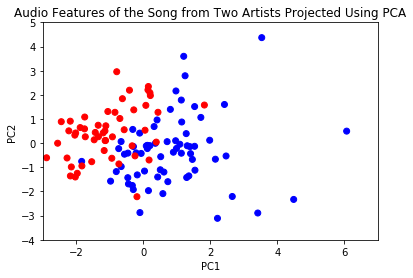

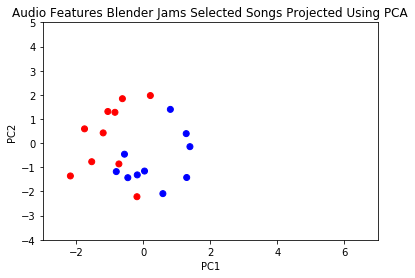

In [34]:
# Plot the results in two dimensional space using PCA
arts = [ 'Moon Hooch', 'The Budos Band' ]

#at = get_related_artists( arts )

at = get_artist_tracks( arts )

tfdf = get_track_feature_df( tracks = at, artist_pair = arts )

recs = get_similar_tracks( artist_pair = arts, get_related = False, scaleing = None, sim_metric = 'cosine' )

sc = StandardScaler( with_mean = True, with_std = True)

sc_tfdf = sc.fit_transform( np.array(tfdf[tfdf.mean().index]) )

sc_tfdf = pd.DataFrame(sc_tfdf, index = tfdf.set_index('Track ID').index)


orig_colors = color_map( tfdf['Artist Col'].values )

sim_colors = color_map( recs['Artist Col'].values )


orig_pca = PCA( n_components = 2 )

orig_pca = orig_pca.fit_transform( sc_tfdf )

orig_pca = pd.DataFrame(orig_pca, index = tfdf.set_index('Track ID').index)

sim_pca = orig_pca.loc[recs.set_index('Track ID').index]

plt.scatter( orig_pca[0], orig_pca[1], color = orig_colors )

plt.title('Audio Features of the Song from Two Artists Projected Using PCA')

plt.xlabel( 'PC1' )

plt.ylabel('PC2')

plt.xlim(-3,7)

plt.ylim(-4,5)


plt.show()


plt.scatter( sim_pca[0], sim_pca[1], color = sim_colors )

plt.title('Audio Features Blender Jams Selected Songs Projected Using PCA')

plt.xlabel( 'PC1' )

plt.ylabel('PC2')

plt.xlim(-3,7)

plt.ylim(-4,5)

plt.show()